## 1) Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.distributions import constraints

from IPython.display import display, clear_output
import pandas as pd
import time
import json
from itertools import product
from collections import namedtuple
from collections import OrderedDict

import random
import math

In [2]:
print(f"Cuda is available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Cuda is available: True
Running on the GPU


## Squashing Function

In [3]:
# implement class wrapper for squashing activation function
class SquashingFunction(nn.Module):
    '''
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Examples:
        m = squashing(beta=25)
        input = torch.randn(2)
        output = m(input)

        Input/Output have same shape:
        input.shape
        output.shape
    '''
    def __init__(self, beta=0.1):
        '''
        Init method.
        '''
        super(SquashingFunction, self).__init__()
        
        self.alpha = 0.5
        #self.beta = 50.0
        self.lam = 1.0
        
        self.beta = Parameter(torch.tensor(beta)) # create a tensor out of beta
        #print("Beta Wert", self.beta)
            
        self.beta.requiresGrad = True # set requiresGrad to true!

        
        

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta:", self.beta.data.item())
        # define beta global for pandas print
        global betas 
        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )

## 3) Functions for Points positions

### 3.1) ClassifyGaus

In [14]:
def classifyGaussData(numSamples):
    """ getting a specific number of gauss data points
    i.e. simple linear data"""
    fprint = "Gaus"
    points = []
    labels = []
    radius = 5
    
    #Points 1
    for i in range(0, numSamples//2):
        x = np.random.normal(-radius//2, 1)
        y = np.random.normal(-radius//2, 1)
        if(x+y>=0):
            points.append([x,y])
            labels.append(0)
        else:
            points.append([x,y])
            labels.append(1)
            
    #Points 2
    for i in range(0, numSamples//2):
        x = np.random.normal(radius//2, 1)
        y = np.random.normal(radius//2, 1)
        if(x+y>=0):
            points.append([x,y])
            labels.append(0)
        else:
            points.append([x,y])
            labels.append(1)
    points = np.array(points, dtype=np.float32)
    # return np.random.permutation(points)
    return points, labels, fprint

### 3.2) Classify Spiral

In [15]:
def classifySpiralData(numSamples):
    fprint = "Spiral"
    points = []
    labels = []
    n = numSamples//2
    # first class with label 0
    for i in range(0, n):
        r = float(i)/ n * 5
        t = 1.75 * i / n * 2 * math.pi + 0
        x = r * math.sin(t)
        y = r * math.cos(t)
        points.append([x,y])
        labels.append(0)
    # second class with label 1
    for i in range(0, n):
        r = float(i) / n * 5
        t = 1.75 * i / n * 2 * math.pi + math.pi
        x = r * math.sin(t)
        y = r * math.cos(t)
        points.append([x,y])
        labels.append(1)
    points = np.array(points, dtype=np.float32)
    # return np.random.permutation(points)
    return points, labels, fprint

### Classify Circle

In [16]:
def classifyCircleData(numSamples):
    fprint = "Circle"
    points = []
    labels = []
    radius = 5
    #getting the positive points inside the circle
    for i in range(0, numSamples//2):
        r = randUniform(0, radius * 0.5)
        angle = randUniform(0, 2 * math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        points.append([x,y])
        labels.append(0)
        
    # getting the negative points outside the circle
    for i in range(0, numSamples//2):
        r = randUniform(radius * 0.7, radius)
        angle = randUniform(0, 2 * math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        points.append([x,y])
        labels.append(1)
    points = np.array(points, dtype=np.float32)
    # return np.random.permutation(points)
    return points, labels, fprint

In [17]:
def randUniform(a, b):
    """ return a random number between a and b"""

    return random.uniform(0, 1) * (b - a) + a

## 4) Generate Points and Labels with Number of samples

In [18]:
# Number of points in Grid
NUM_SAMPLES = 400
fprint = None

In [19]:
# Set Function for Point generation
# X -> points, Y -> Labels
X, Y, fprint = classifyGaussData(NUM_SAMPLES)

In [20]:
print(fprint)

Gaus


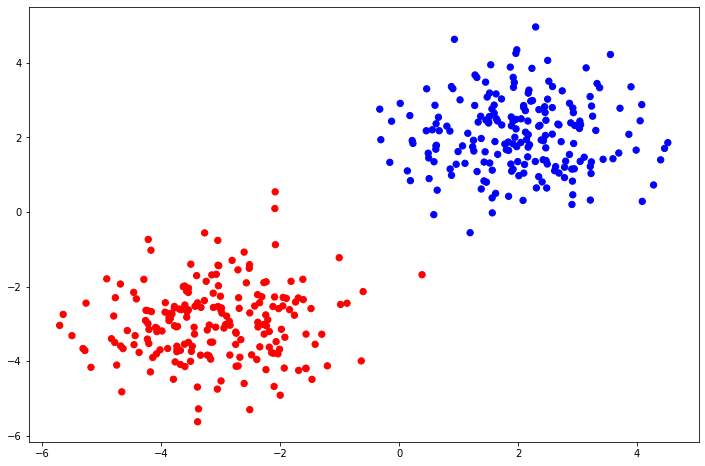

In [21]:
# Print Points in Grid
plt.figure(figsize=(12,8))
plt.scatter(X[:,0],X[:,1],s=40, c=Y, cmap=plt.cm.bwr)

In [12]:
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=.1)

In [13]:
train_X = Variable(torch.Tensor(train_X).float())
test_X = Variable(torch.Tensor(test_X).float())
train_y = Variable(torch.Tensor(train_y).long())
test_y = Variable(torch.Tensor(test_y).long())

In [14]:
print(train_X)

tensor([[ 1.0838e-01,  8.9169e-02],
        [-9.5990e-02,  1.7867e-03],
        [ 2.9587e+00, -3.4950e+00],
        [-2.3623e-01, -2.3919e-01],
        [ 4.1056e+00,  1.9373e-01],
        [ 3.5041e+00, -5.3049e-01],
        [-6.4807e-01, -8.1367e-02],
        [-2.4720e-01, -3.5226e+00],
        [-9.2447e-02,  1.8450e-01],
        [ 4.4217e-01,  3.9093e+00],
        [-3.1169e+00, -2.6281e+00],
        [ 1.3549e+00, -2.2243e-02],
        [ 1.8665e-01, -1.0784e+00],
        [-3.5621e+00, -2.4715e-01],
        [-8.0956e-01,  2.2318e+00],
        [ 2.5620e-03, -2.6937e-02],
        [-2.7067e-01, -1.6875e-01],
        [-1.5345e-01, -2.7339e-01],
        [-4.5975e+00,  1.2114e+00],
        [ 4.0708e+00, -2.4889e+00],
        [ 1.3235e-01, -2.2406e-01],
        [ 4.9672e-01,  1.8426e+00],
        [-3.0397e-01,  1.7636e+00],
        [ 4.8689e+00,  1.1210e+00],
        [ 1.8725e+00,  1.5242e+00],
        [-1.4653e+00,  1.0748e-01],
        [-3.8506e+00,  2.7344e+00],
        [-1.7837e+00,  1.686

In [15]:
print(train_y)

tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,

## 5) Network implementation

In [16]:
'''
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(in_features=2, out_features=64)
        
        #self.dout = nn.Dropout(0.2)
        self.activation = SquashingFunction()
        
    #This must be implemented
    def forward(self,x):
        x=self.activation(self.fc1(x))
        #x = self.dout(x)
        x=self.activation(self.fc2(x))
        x=self.out(x)
        x=self.activation(x)
        return x
'''

'\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net,self).__init__()\n        \n        self.fc1 = nn.Linear(in_features=2, out_features=64)\n        \n        #self.dout = nn.Dropout(0.2)\n        self.activation = SquashingFunction()\n        \n    #This must be implemented\n    def forward(self,x):\n        x=self.activation(self.fc1(x))\n        #x = self.dout(x)\n        x=self.activation(self.fc2(x))\n        x=self.out(x)\n        x=self.activation(x)\n        return x\n'

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(in_features=2, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=2)

        
        #self.dout = nn.Dropout(0.2)
        self.activation = SquashingFunction()
        
    #This must be implemented
    def forward(self,x):
        x=self.activation(self.fc1(x))
        #x = self.dout(x)
        x=self.activation(self.fc2(x))
        x=self.out(x)
        x=self.activation(x)
        return x

## 6) Training

### 6.1) Runbuilder

In [18]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run', params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

In [19]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.accuracy = 0
    train_accuracy = 0
    test_accuracy = 0

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.epoch_count = 0


  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0


  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time
    
    # record epoch loss and accuracy
    #accuracy = accuracy_score(model.predict(X),y)
    
    # train accuracy
    predict_out = net(train_X)
    _, predict_y = torch.max(predict_out, 1)
    train_accuracy = accuracy_score(train_y.data, predict_y.data)
    
    # test accuracy
    predict_out = net(test_X)
    _, predict_y = torch.max(predict_out, 1)
    test_accuracy = accuracy_score(test_y.data, predict_y.data)
   
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    
    #results["betas"] = betas
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = self.epoch_loss
    results["train_accuracy"] = train_accuracy
    results["test_accuracy"] = test_accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration
    
    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    if results["epoch"] % 100 == 0:
        clear_output(wait=True)
        display(df)


  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item()


  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)


  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  

  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):
    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

### 6.2) Learning Parameters

In [20]:
params = OrderedDict(
    lr = [.001],                 # .01, .001, .00001
    epochs = [2000]
)

In [21]:
m = RunManager()

### 6.3) Train loop

In [22]:
# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):
    #Initialize the model    
    net=Net()
    
    #Define loss criterion
    criterion = nn.CrossEntropyLoss()
    #Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=run.lr)
    
    losses=[]
    m.begin_run(run, net)
    for epoch in range(run.epochs):
        m.begin_epoch()
        #Clear the previous gradients
        optimizer.zero_grad()
        out = net(train_X)
        #Compute Cross entropy loss
        loss = criterion(out, train_y)
        #Add loss to the list
        losses.append(loss.item())
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()
        
        m.track_loss(loss)
        m.end_epoch()
    m.end_run()

,run,epoch,loss,train_accuracy,test_accuracy,epoch duration,run duration,lr,epochs
0,1,1,0.692972,0.516667,0.35,0.017002,0.017002,0.001,2000
1,1,2,0.692925,0.516667,0.35,0.005001,0.030005,0.001,2000
2,1,3,0.692881,0.516667,0.35,0.005001,0.040007,0.001,2000
3,1,4,0.692840,0.516667,0.35,0.004001,0.049009,0.001,2000
4,1,5,0.692801,0.516667,0.35,0.005002,0.058012,0.001,2000
...,...,...,...,...,...,...,...,...,...
1995,1,1996,0.313346,1.000000,1.00,0.005001,28.646969,0.001,2000
1996,1,1997,0.313346,1.000000,1.00,0.004001,28.664973,0.001,2000
1997,1,1998,0.313345,1.000000,1.00,0.005001,28.684978,0.001,2000
1998,1,1999,0.313345,1.000000,1.00,0.004001,28.704983,0.001,2000


### 6.4) Results Final

number of epoch 1999 loss tensor(0.3133)
Train Accuracy: 1.0
Test Accuracy: 1.0


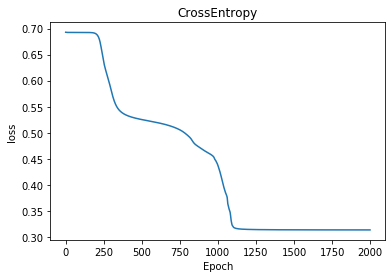

In [23]:
plt.title("CrossEntropy")
plt.xlabel("Epoch")
plt.ylabel("loss")
print('number of epoch', epoch, 'loss', loss.data)
predict_out = net(train_X)
_, predict_y = torch.max(predict_out, 1)
print("Train Accuracy:",accuracy_score(train_y.data, predict_y.data))
predict_out = net(test_X)
_, predict_y = torch.max(predict_out, 1)
print("Test Accuracy:",accuracy_score(test_y.data, predict_y.data))
plt.plot(losses)

## 7) Plot Network

In [24]:
#Defining the mesh for contour plots
x = np.linspace(-7, 7, 50)
y = np.linspace(-7, 7, 40)
mesh = np.meshgrid(x, y)
a=np.zeros((2000,2))
a[:,0]=np.ravel(mesh[0])
a[:,1]=np.ravel(mesh[1])
contour_test=torch.Tensor(a)

In [25]:
predict_out = net(contour_test)
contour_plot=predict_out.detach().numpy()[:,1]

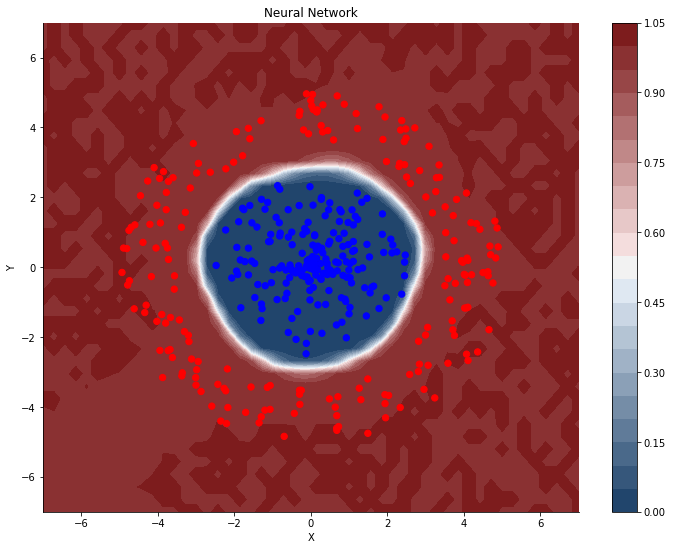

In [26]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour=ax.contourf(mesh[0], mesh[1], contour_plot.reshape(40,50),20, cmap=cmap);
cbar = plt.colorbar(contour)
ax.scatter(X[:,0],X[:,1],s=40, c=Y, cmap=plt.cm.bwr)
sns.despine();
ax.set(xlabel='X', ylabel='Y', title='Neural Network');

## 8) Save Training Data into CSV file

In [27]:
# when all runs are done, save results to files
m.save(f"functiontype_{fprint}_learningrate_{params['lr'][0]}_epochs_{params['epochs'][0]}_{int(time.time())}")